Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.1) 나무위키 최신 변경 문서의 키워드 분석

### 바로가기

- [<Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기](#<Step1.-크롤링>-:-크롤링으로-웹-데이터-가져오기)
    - [BeautifulSoup을 이용한 웹 크롤링]
    - [나무위키 최근변경 데이터 크롤링]
- [<Step2. 추출> : 키워드 추출](#<Step2.-추출>-:-키워드-추출)
    - [텍스트 데이터 전처리]
    - [말뭉치 만들기]
    - [konlpy를 이용한 키워드 추출]
    - [키워드 가다듬기]
- [<Step3. 시각화> : 워드 클라우드 시각화](#<Step3.-시각화>-:-워드-클라우드-시각화)
    - [pytagcloud 사용하기]
    - [나무위키 키워드 시각화]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기

### [BeautifulSoup을 이용한 웹 크롤링]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install requests`
    - (env_name) `pip install beautifulsoup4`
    - (env_name) `pip install lxml`
- 혹은 아래의 코드로 라이브러리를 설치합니다.

In [2]:
!pip install requests beautifulsoup4 lxml

-----

##### 페이지 리스트 가져오기

In [3]:
import requests
from bs4 import BeautifulSoup
import re

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://search.naver.com/search.naver?&where=news&query=%EC%A0%84%EB%8F%99%ED%82%A5%EB%B3%B4%EB%93%9C&sm=tab_tmr&frm=mr&nso=so:r,p:all,a:all&sort=0"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [6]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://www.naver.com"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)

# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

-----

##### 페이지내 텍스트 구조 확인

In [7]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="article")
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
content_paragraphs = contents_table.find_all(name="div", attrs={"class":"news_tit"})
content_corpus_list = []

for paragraphs in content_paragraphs:
    content_corpus_list.append(paragraphs.text)
content_corpus = "".join(content_corpus_list)
# print(type(content_corpus))
print(title.text)
print("\n")
print(category.text)
print("\n")
print(content_corpus)

IndexError: list index out of range

-----

### [나무위키 최근변경 데이터 크롤링]

In [10]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 “분류”라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

In [11]:
# 데이터 프레임을 출력합니다.
df.head(5)

,title,category,content_text
0,종북주의자,종북주의자,가입 후 15일이 지나야 편집 가능한 문서입니다.타국에 대한 추종미국빠독일빠러...
1,인천SK행복드림구장,대한민국의 야구장SK 와이번스인천광역시,KBO 리그홈구장KBO 리그홈구장 [ 펼치기 · 접기 ]구단홈구장제2구장두산 베어스...
2,주르르,우왁굳1997년 출생대한민국의 여성 인터넷 방송인/ㅈ유튜버/ㅈ트위치 스트리머/ㅈ나무...,우왁굳의 게임방송 고정멤버 1기동동쿤김반푼이냉동참치띵킹주르르아크팩토리뢴트게늄기사단놀...
3,시계 갤러리,디시인사이드,디시인사이드의 갤러리중 하나인 시계 갤러리를 다루는 문서이다.시계 관련 정보가 오고...
4,인천 버스 909,인천광역시 급행간선버스2009년 개업한 버스 노선,인천광역시 급행버스광역ㆍ급행ㆍ좌석ㆍ간선ㆍ지선ㆍ순환ㆍ마을9195979899904-1...


-----

# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [12]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [13]:
print(text_cleaning(df['content_text'][0]))

  가입 후 일이 지나야 편집 가능한 문서입니다타국에 대한 추종미국빠독일빠러시아빠소련빠중국빠일본빠북한빠영국빠프랑스빠한국빠나치빠 북한에 대한 감정혐북반북친북종북 개요 특징 정의 및 유래 발생 원인 반공에 대한 반발 사회에 대한 불만 핵무기에 대한 동경 몰락 근황 종북과 색깔론 종북주의자들의 행동 북한의 경제에 대한 평가 북한의 외교에 대한 평가 북한의 군사력에 대한 평가 북한의 정치와 인권에 대한 평가 한국전쟁에 대한 평가 다른 인물민족사상과의 관계 모순적인 행태 정치적 활동 찬양고무죄 관련 사건사고 북한 지배층들의 인식 평가 기타 종북 인사 및 단체 관련 문서종북주의자 혹은 종북은 북한의 김씨 정권을 위시한 지배층을 결사옹위하고 추종하며 북한 주민들의 참상을 철저히 외면하거나 왜곡하는 이들을 일컫는 한국의 신조어이다 따를 종과 북한의 북의 의미결합으로 이뤄진 한국의 신조어로서 많은 사람들이 종북이라는 단어가 신조어라는데 의문을 표하겠지만 엄연히 년대 이후부터 대중적으로 사용된 단어로서 년대까지만 하더라도 종북이 아닌 주사파가 훨씬 더 자주 사용된 단어였었다 당장 네이버의 뉴스라이브러리로 검색해보아도 년대까지 거의 쓰이지 않던 단어가 종북이라는 사실을 알 수 있을 정도이다 링크 당연하지만 년대 이후에야 겨우 사용된 신조어인 만큼 국립국어원의 표준국어대사전에도 전혀 등재가 되어있지 않은 단어이다어떤 사람들은 세기에 들어왔는데도 설마 지금도 종북주의자가 있겠냐고 말하면서 종북주의자를 단순히 보수세력이 정치 공세를 하기 위해 만들어낸 지금은 존재하지 않는 과거의 존재로 치부하기도 하는데 비록 예전에 비해서 많이 줄어들긴 했지만 세기의 대한민국에서도 종북주의자는 엄연히 존재한다 착각하면 안 될 것은 실제로 종북주의를 반정부 인사를 척결하는 데 이용하는 사례는 분명히 있지만 그렇다고 해서 실체가 없는 것을 용공조작한 것이 아니라는 점이다이런 인물들의 또다른 레파토리로는 요즘 세상에 북한의 체제를 찬양하고 독재세습을 좋아하는 사람이 어디에 있냐며 있더라도 정신병자란 주장인

In [11]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,유엘섬,년 데뷔트위치 스트리머ㅇ유튜버ㅇ대한민국의 남성 인터넷 방송인ㅇ한국 남가수ㅇ년 출생의...,한섬유엘섬본명한섬희신체활동명한섬닉네임유엘섬섬별명섬생님섬냥이고든섬지낭심저격수발락더그냥...
1,광역급행버스,광역급행버스년 개업한 버스 노선,국토교통부 광역급행버스 펼치기 접기 고양시김포시남양주시성남시수원시안양시오산시용...
2,화랑철권,철권등장인물한국인 캐릭터서브 주인공게임라이벌 캐릭터격투가 캐릭터반동인물게임나무위키 ...,철권 의 출전 캐릭터 펼치기 접기 정렬 가나다순 간류 아쿠마고우키 기가스 ...
3,,한국의 기업패션 브랜드체육용품 제조사년 기업,은는 여기로 연결됩니다 개의 한 종류에 대한 내용은 필라 브라질레이로 문서를의 ...
4,화웨이의 한국 내 통신장비 납품 관련 논란,한국의 통신회사논란화웨이논란 및 문제점 그리고 비판,이 문서는이 문단은 토론을 통해 대한민국 통신 사 유선망 및 백본망에 화웨이 장비를...


-----

### [말뭉치 만들기]

In [14]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

종북주의자 인천SK행복드림구장 주르르 시계 갤러리 인천 버스 909 나는 가수다 2/방영기록/9월 틀:인천 도시철도 전동차 매드클라운 이안 맥켈런 인천 버스 순환43 인천 버스 97 한국외국어대학교/교통 인천 버스 순환44 인천 버스 인천e음45 Fate/Grand Order/스토리/올림포스 임학역 인천 버스 순환31 이시카리 아리에 인천 버스 81 인천 버스 98 종이종이 열매 인천 버스 9 투구꽃 살인사건 인천 버스 순환56 LCK 스토브리그/2020 오작교 형제들 인천 버스 80 인천 버스 순환92 션 오말리 인천 버스 908 뒷목잡는맹꽁이방 인천국제공항철도/역 목록 인천 버스 905 SK에너지 현우진 나훈아 인천 버스 인천e음55 파일:Incheonmetro1_icon.svg 인천 버스 95 시간지기 쿠키 슬라임 랜처/실험실 인천 버스 9100 DAMWON Gaming/리그 오브 레전드 새끼손가락 손톱을 기르는 이유 인천 버스 904-1 캐나다/경제 인천 버스 91 군바리 롤랑(롤랑롤랑) 작전역 인천 버스 903 Lil Peep 러시 듀얼 인천 버스 순환52 인천 도시철도 1호선 고증/작품별 고증 완성도 레전드 오브 룬테라/그림자 군도 울트라맨 베리알/작품별 행적 KBO 플레이오프/2020년 유비(삼국지톡) 인천 버스 800 인천 버스 82 인천 버스 790 강철의 왈츠/사건사고 파일:cotton_!23.jpg 인천교통공사 1000호대 전동차 인천교통공사 인천연송고등학교 루이사 인천 버스 순환83 감찰의 아사가오 워싱턴 내셔널스 인천 버스 904 틀:인천 도시철도망 구축계획 변경안 알버스 덤블도어 인천 버스 인천e음71 파일:Incheonmetro1_icon2.svg カンナ 힐스테이트 송도 더스카이 인천터미널역 인천 버스 순환46 인천 버스 9201 인천 버스 99 인천 버스 9300 인천 버스 9500 인천시청역 인천 버스 87 캠퍼스타운역 인천 버스 순환91 테크노파크역 인천대입구역 블랙 라군/애니메이션 지식정보단지역 


-----

### [konlpy를 이용한 키워드 추출]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
- 아래의 방법으로 설치해도 실행되지 않는다면, http://konlpy.org/ko/latest/install/ 를 참고하세요.
    - Install
        - 1. Java를 설치합니다. (https://java.com/ko/download/)
        - 2. c++ 컴파일러를 설치합니다. 
            - 윈도우 : `Microsoft Visual C++ 14.0` 설치 권장, https://visualstudio.microsoft.com/ko/downloads/
            - Mac OS : `Xcode` 설치 권장
            - Linux : `gcc` 설치 권장
        - 3. 아래와 같은 파이썬 패키지를 설치합니다. **konlpy 버전을 반드시 0.5.1로 해주어야 합니다. 2020년 현재(9월) 기준, 최신 버전 konlpy 에서는 일부 개발환경에서 자바 에러가 발생합니다.**
            - (env_name) `pip install konlpy==0.5.1`
            - (env_name) `pip install jpype1`
            - (env_name) `pip install Jpype1-py3`

In [15]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [16]:
count

Counter({'가입': 7,
         '후': 242,
         '편집': 34,
         '문서': 507,
         '타국': 3,
         '대한': 228,
         '추종': 13,
         '미국': 136,
         '빠': 3,
         '독일': 14,
         '아빠': 6,
         '소련': 16,
         '빠중국빠': 1,
         '일본': 98,
         '빠북한빠영국빠': 1,
         '프랑스': 11,
         '빠한국빠나치빠': 1,
         '북한': 309,
         '감정': 29,
         '혐북': 1,
         '북': 23,
         '친북': 19,
         '종북': 88,
         '개요': 84,
         '특징': 78,
         '정의': 9,
         '및': 158,
         '유래': 15,
         '발생': 36,
         '원인': 21,
         '반공': 6,
         '반발': 12,
         '사회': 52,
         '불만': 18,
         '핵무기': 9,
         '동경': 10,
         '몰락': 25,
         '근황': 2,
         '색깔론': 3,
         '종북주의자': 74,
         '행동': 40,
         '경제': 52,
         '평가': 79,
         '외교': 12,
         '군사력': 5,
         '정치': 16,
         '인권': 29,
         '한국': 188,
         '전쟁': 64,
         '다른': 220,
         '인물': 118,
         '민족': 32,
  

-----

### [키워드 가다듬기]

##### 한글자 키워드 제거

In [17]:
# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'인천': 1286, '문서': 507, '역사': 463, '때문': 443, '이전': 435, '사항': 427, '노선': 417, '문단': 394, '쿠키': 360, '호선': 347, '순환': 339, '인천광역시': 319, '사람': 313, '토론': 313, '이후': 312, '자신': 311, '합의': 311, '북한': 309, '카드': 292, '버스': 283, '덤블도어': 279, '시대': 269, '경우': 264, '공격': 258, '정도': 257, '고증': 257, '사실': 236, '시즌': 231, '하나': 229, '대한': 228, '운행': 227, '사용': 222, '다른': 220, '울트라맨': 219, '열매': 215, '모습': 214, '당시': 207, '경기': 207, '효과': 207, '시간': 200, '이용': 198, '사건': 194, '도시철도': 193, '송도': 191, '한국': 188, '드라마': 188, '문제': 187, '지역': 186, '또한': 185, '계약': 183, '위해': 182, '생각': 179, '방송': 177, '현재': 176, '가장': 176, '해리': 176, '아파트': 174, '상황': 171, '유비': 171, '상태': 169, '아군': 168, '시작': 167, '터미널': 167, '감독': 166, '대해': 162, '변경': 162, '소환': 160, '체력': 157, '조조': 157, '실제': 153, '게임': 153, '정보': 152, '학교': 152, '관련': 151, '등장': 151, '베리': 151, '모든': 148, '구간': 146, '종료': 145, '개통': 145, '아사': 144, '서울': 143, '사망': 142, '내용': 139, '국제': 138, '나훈아': 137, '미국': 136, '교통': 136, '다시': 135

-----

##### 불용어 제거

In [28]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [19]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [29]:
# 키워드 데이터에서 불용어를 제거합니다.
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'인천광역시': 46, '버스': 46, '개업': 41, '노선': 37, '도시철도': 21, '대한민국': 14, '나무': 14, '위키': 14, '프로젝트': 14, '철도': 12, '순환버스': 12, '인천': 12, '간선': 11, '호선': 11, '철도역': 9, '캐릭터': 9, '한국': 8, '정거장': 8, '지하철역': 8, '시리즈': 8, '드라마': 7, '출생': 6, '인터넷': 6, '급행': 6, '송도국제도시': 6, '출신': 5, '급행버스': 5, '울트라': 5, '파일': 5, '일본': 5, '미국인': 4, '래퍼': 4, '미국': 4, '광역버스': 4, '롤랑': 4, '애니메이션': 4, '방송인': 3, '등장인물': 3, '빌런': 3, '예정': 3, '오브': 3, '레전드': 3, '기여': 3, '사용자': 3, '가수': 2, '둘러보기': 2, '교통': 2, '데뷔': 2, '힙합': 2, '역대': 2, '대학교': 2, '사건': 2, '리그': 2, '관련': 2, '설립': 2, '강사': 2, '쿠키런': 2, '웹툰': 2, '주인공': 2, '유희왕': 2, '울트라맨': 2, '시내버스': 2, '좌석버스': 2, '회사': 2, '학교': 2, '고등학교': 2, '해리': 2, '포터': 2, '교체': 2, '주택': 2, '종북주의자': 1, '야구장': 1, '와이번스': 1, '여성': 1, '유튜버': 1, '트위치': 1, '스트리머': 1, '디시인사이드': 1, '함안': 1, '조씨': 1, '일리노이': 1, '참가자': 1, '개신교': 1, '자재': 1, '맥심': 1, '표지': 1, '모델': 1, '영주권자': 1, '영국': 1, '배우': 1, '게이': 1, '대영제국': 1, '훈장': 1, '외국어': 1, '그리스': 1, '로마': 1, '신화': 1, '창작물': 1, '원피스': 1, '미디어': 1,

-----

# <Step3. 시각화> : 워드 클라우드 시각화

### [pytagcloud 사용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install pytagcloud pygame simplejson`
- 그리고 아래와 같은 경로에 한글 폰트(예: NanumBarunGothic.ttf) 파일을 옮깁니다. 
    - Mac OS : /{anaconda_path}/envs/{env_name}/lib/python3.7/site-packages/pytagcloud/fonts
    - Windosw OS : \{anaconda_path}\envs\{env_name}\Lib\site-packages\pytagcloud\fonts
    - `폰트 다운로드 : http://hangeul.naver.com/webfont/NanumGothic/NanumGothic.ttf`
- 파일을 옮긴 후, 파이썬 가상환경을 재실행 하여 주피터를 다시 실행해줍니다. 그래도 아래의 코드가 실행되지 않는 경우는 다음과 같은 작업을 수행합니다.
    - 위의 경로에서 font.json 파일을 편집합니다.
    - 아래와 같은 코드를 추가하고 font.json 파일을 저장합니다.
    - {
                "name": "NanumGothic",
                "ttf": "NanumGothic.ttf",
                "web": "http://fonts.googleapis.com/css?family=Nanum+Gothic"
        },

In [25]:
import random
import pytagcloud
import webbrowser

# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

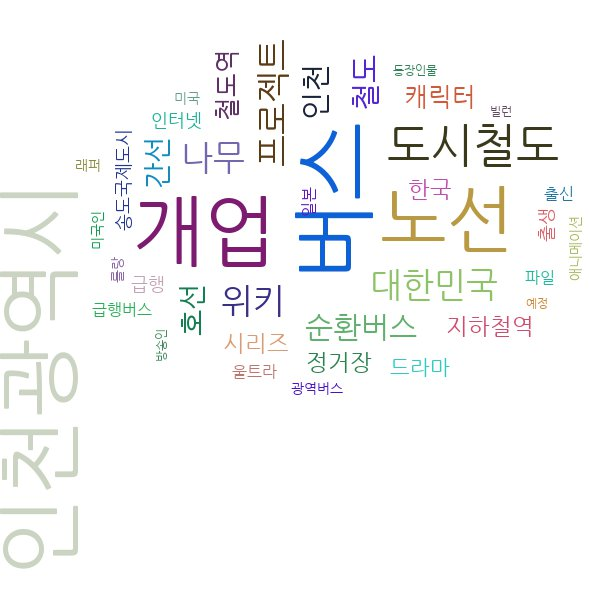

In [26]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')

-----

### [나무위키 키워드 시각화]

##### 제목 키워드

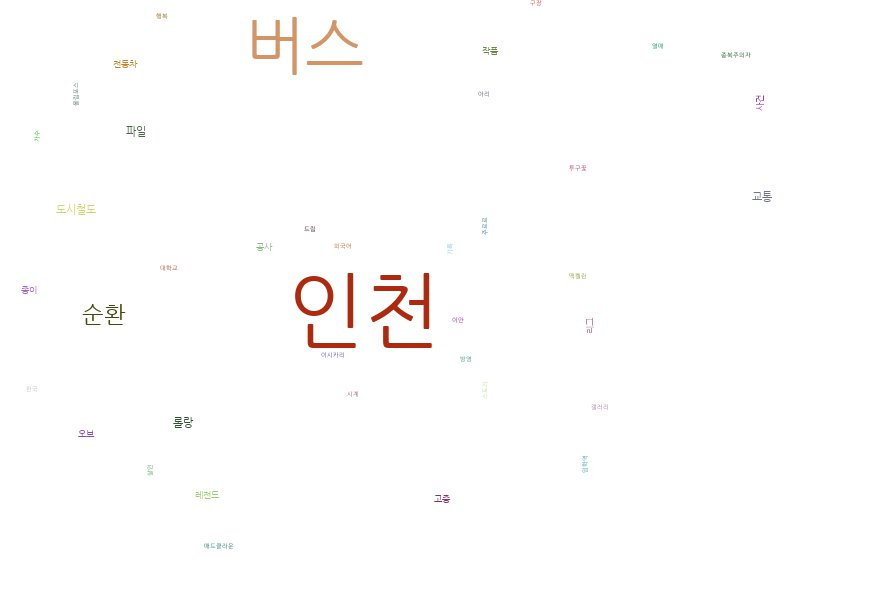

In [23]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

-----

##### 카테고리 키워드

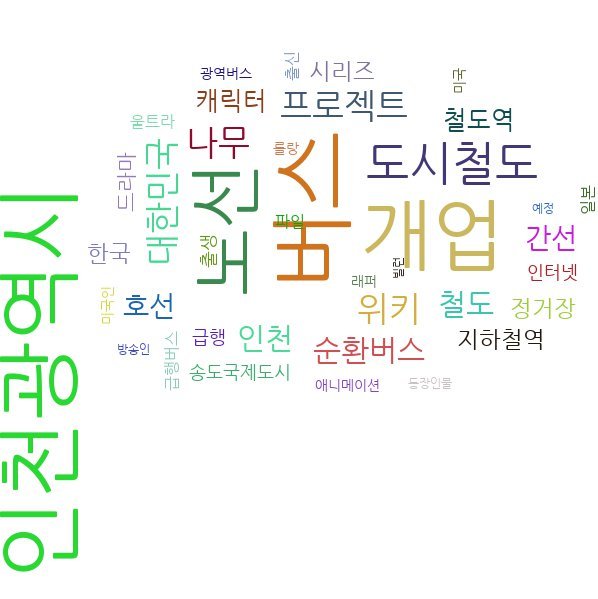

In [24]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')